### Aim of this notebook is to predict the forward return of stocks in the S&P 500 Index. To start with, we will simply predict the sign of the return (Positive, Negative, Zero) but can later move on to regression.

# Imports

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from warnings import simplefilter
import seaborn as sns
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# Get data

In [2]:
# Get raw data
companies = pd.read_csv("/kaggle/input/sp-500-stocks/sp500_companies.csv")
index = pd.read_csv("/kaggle/input/sp-500-stocks/sp500_index.csv", parse_dates=['Date'])
stocks = pd.read_csv("/kaggle/input/sp-500-stocks/sp500_stocks.csv", parse_dates=['Date'])
macro = pd.read_csv("/kaggle/input/macroeconomic-factors-affecting-us-housing-prices/DATA.csv", parse_dates=['DATE'])

In [3]:
companies.head(10)

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,414.74,3082476060672,1.251820e+11,0.170,Redmond,WA,United States,221000.0,Microsoft Corporation develops and supports so...,0.063286
1,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,183.05,2806907142144,1.296290e+11,-0.043,Cupertino,CA,United States,150000.0,"Apple Inc. designs, manufactures, and markets ...",0.057629
2,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,898.78,2246949994496,3.448000e+10,2.653,Santa Clara,CA,United States,29600.0,NVIDIA Corporation provides graphics and compu...,0.046132
3,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,168.65,2093435584512,1.097230e+11,0.154,Mountain View,CA,United States,180895.0,Alphabet Inc. offers various products and plat...,0.042980
4,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,170.29,2093340950528,1.097230e+11,0.154,Mountain View,CA,United States,180895.0,Alphabet Inc. offers various products and plat...,0.042978
5,NMS,AMZN,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail,187.48,1951029264384,9.660900e+10,0.125,Seattle,WA,United States,1525000.0,"Amazon.com, Inc. engages in the retail sale of...",0.040057
6,NMS,META,"Meta Platforms, Inc.","Meta Platforms, Inc.",Communication Services,Internet Content & Information,476.20,1207895588864,6.844700e+10,0.273,Menlo Park,CA,United States,69329.0,"Meta Platforms, Inc. engages in the developmen...",0.024799
7,NYQ,BRK-B,Berkshire Hathaway Inc. New,Berkshire Hathaway Inc.,Financial Services,Insurance - Diversified,412.05,889525239808,1.070460e+11,0.052,Omaha,NE,United States,396500.0,"Berkshire Hathaway Inc., through its subsidiar...",0.018263
8,NYQ,LLY,Eli Lilly and Company,Eli Lilly and Company,Healthcare,Drug Manufacturers - General,760.00,722307776512,1.337370e+10,0.260,Indianapolis,IN,United States,43000.0,"Eli Lilly and Company discovers, develops, and...",0.014830
9,NMS,AVGO,Broadcom Inc.,Broadcom Inc.,Technology,Semiconductors,1332.80,617647505408,2.040400e+10,0.164,Palo Alto,CA,United States,20000.0,"Broadcom Inc. designs, develops, and supplies ...",0.012681


In [4]:
index.head(10)

,Date,S&P500
0,2014-05-12,1896.65
1,2014-05-13,1897.45
2,2014-05-14,1888.53
3,2014-05-15,1870.85
4,2014-05-16,1877.86
5,2014-05-19,1885.08
6,2014-05-20,1872.83
7,2014-05-21,1888.03
8,2014-05-22,1892.49
9,2014-05-23,1900.53


In [5]:
stocks.head(10)

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,MMM,40.835026,69.414719,69.774246,69.122070,69.473244,3640265.0
1,2010-01-05,MMM,40.579281,68.979935,69.590302,68.311035,69.230766,3405012.0
2,2010-01-06,MMM,41.154751,69.958191,70.735786,69.824417,70.133781,6301126.0
3,2010-01-07,MMM,41.184265,70.008362,70.033447,68.662209,69.665550,5346240.0
4,2010-01-08,MMM,41.474476,70.501671,70.501671,69.648827,69.974915,4073337.0
5,2010-01-11,MMM,41.307236,70.217392,70.735786,69.740807,70.551842,3500812.0
6,2010-01-12,MMM,41.341667,70.275917,70.384613,69.648827,69.882942,3626033.0
7,2010-01-13,MMM,41.208862,70.050163,70.326088,69.565216,70.326088,3709992.0
8,2010-01-14,MMM,41.071148,69.816055,70.175583,69.749161,70.016724,3150384.0
9,2010-01-15,MMM,41.007206,69.707359,70.309364,69.289299,69.832779,4730180.0


In [6]:
macro.head(10)

,DATE,UNRATE(%),CONSUMER CONF INDEX,PPI-CONST MAT.,CPIALLITEMS,INFLATION(%),MORTGAGE INT. MONTHLY AVG(%),MED HOUSEHOLD INCOME,CORP. BOND YIELD(%),MONTHLY HOME SUPPLY,% SHARE OF WORKING POPULATION,GDP PER CAPITA,QUARTERLY REAL GDP,QUARTERLY GDP GROWTH RATE (%),CSUSHPISA
0,2022-01-05,3.6,106.4,352.857,123.322800,8.581511,5.2300,NaN,4.13,8.4,NaN,74737,19699.465,-0.144227,120.724
1,2022-01-04,3.6,107.3,343.730,121.978170,8.258629,4.9825,NaN,3.76,8.4,NaN,74737,19699.465,-0.144227,121.813
2,2022-01-03,3.6,107.2,345.852,121.301004,8.542456,4.1720,NaN,3.43,7.0,NaN,73289,19727.918,-0.395692,122.888
3,2022-01-02,3.8,110.5,343.583,119.702806,7.871064,3.7625,NaN,3.25,6.0,NaN,73289,19727.918,-0.395692,123.831
4,2022-01-01,4.0,113.8,345.742,118.619339,7.479872,3.4450,NaN,2.93,5.7,NaN,73289,19727.918,-0.395692,124.780
5,2021-01-12,3.9,115.8,335.032,117.629537,7.036403,3.0980,NaN,2.65,5.6,64.924129,72171,19806.290,1.680778,125.734
6,2021-01-11,4.2,109.5,328.940,117.269225,6.809003,3.0675,NaN,2.62,6.2,64.924129,72171,19806.290,1.680778,126.669
7,2021-01-10,4.6,113.8,322.120,116.695849,6.221869,3.0675,NaN,2.68,6.9,64.924129,72171,19806.290,1.680778,127.622
8,2021-01-09,4.7,109.3,317.136,115.734314,5.390349,2.9000,NaN,2.53,6.1,64.924129,69824,19478.893,0.570948,128.461
9,2021-01-08,5.2,113.8,313.083,115.420835,5.251272,2.8425,NaN,2.55,6.5,64.924129,69824,19478.893,0.570948,129.355


In [7]:
########################################################
# Join into one wide table which will be our raw dataset
########################################################
# Join index table onto stocks table
df = stocks.merge(
    right=index,
    how='left',
    left_on='Date',
    right_on='Date'
)

# Join companies table onto stocks and index table, dropping some unecessary columns from companies table
df = df.merge(
    right=companies[['Symbol', 'Sector',]],
    how='left',
    left_on='Symbol',
    right_on='Symbol'
)

# Since macro is month start data, get YYYYMM to use as a column to join on
macro['YYYYMM'] = macro['DATE'].dt.strftime('%Y%d%m').str[:6]
df['YYYYMM'] = df['Date'].dt.strftime('%Y%m%d').str[:6]

# Join macro table onto dataframe
df = df.merge(
    right=macro,
    how='left',
    left_on='YYYYMM',
    right_on='YYYYMM'
)

###################################################################
# Trim data for start and end dates and drop columns used for joins
###################################################################

# Drop dates older than 10 years ago (S&P only provides data with 10 year rolling history)
ten_years_ago = datetime.now() - timedelta(days=365.25*10)
df = df[df['Date'] >= ten_years_ago].reset_index(drop=True)

# Drop dates after 1st May 2022 (this is when the macro data ends)
df = df[df['Date'] <= pd.to_datetime("2022-05-01")]

# Drop columns used to join and other unecessary columns and rename columns
to_drop = ['DATE', 'YYYYMM', 'MONTHLY HOME SUPPLY', '% SHARE OF WORKING POPULATION', 'PPI-CONST MAT.', 'MED HOUSEHOLD INCOME']
df.drop(to_drop, axis=1, inplace=True)
df.rename(
    mapper={
        'INFLATION(%)': 'Inflation (%)',
        'MORTGAGE INT. MONTHLY AVG(%)': 'Monthly Average Mortgage Rate (%)',
        'CORP. BOND YIELD(%)': 'Corporate Bond Yield',
        'GDP PER CAPITA': 'GDP Per Capita',
        'QUARTERLY REAL GDP': 'Quarterly Real GDP',
        'QUARTERLY GDP GROWTH RATE (%)': 'Quarterly GDP Growth Rate (%)',
        'CSUSHPISA': 'Home Price Index',
        'CPIALLITEMS': 'CPI All Items',
        'CONSUMER CONF INDEX': 'Consumer Confidence Index',
        'UNRATE(%)': 'Unemployment Rate (%)'
    },
    axis=1,
    inplace=True
)

# Order by date for ease
df.sort_values(
    by='Date',
    inplace=True,
    ignore_index=True
)

# Reset index
df = df.reset_index(drop=True)

In [8]:
df.columns

Index(['Date', 'Symbol', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'S&P500', 'Sector', 'Unemployment Rate (%)',
       'Consumer Confidence Index', 'CPI All Items', 'Inflation (%)',
       'Monthly Average Mortgage Rate (%)', 'Corporate Bond Yield',
       'GDP Per Capita', 'Quarterly Real GDP', 'Quarterly GDP Growth Rate (%)',
       'Home Price Index'],
      dtype='object')

# EDA

## Column info

In [9]:
# Column types and non-null counts
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010024 entries, 0 to 1010023
Data columns (total 20 columns):
 #   Column                             Non-Null Count    Dtype         
---  ------                             --------------    -----         
 0   Date                               1010024 non-null  datetime64[ns]
 1   Symbol                             1010024 non-null  object        
 2   Adj Close                          978295 non-null   float64       
 3   Close                              978295 non-null   float64       
 4   High                               978295 non-null   float64       
 5   Low                                978295 non-null   float64       
 6   Open                               978295 non-null   float64       
 7   Volume                             978295 non-null   float64       
 8   S&P500                             1010024 non-null  float64       
 9   Sector                             1010024 non-null  object        
 10  Unempl

In [10]:
# Distribution of columns
print(df.describe())

                                Date      Adj Close          Close  \
count                        1010024  978295.000000  978295.000000   
mean   2018-05-05 13:51:09.322708992     105.116418     112.329445   
min              2014-05-12 00:00:00       0.700000       0.700000   
25%              2016-05-08 06:00:00      37.916275      43.049999   
50%              2018-05-05 12:00:00      64.430000      72.919998   
75%              2020-05-04 06:00:00     115.385849     124.839996   
max              2022-04-29 00:00:00    5959.330078    5959.330078   
std                              NaN     191.205741     191.471728   

                High            Low           Open        Volume  \
count  978295.000000  978295.000000  978295.000000  9.782950e+05   
mean      113.578369     111.034857     112.323822  5.197271e+06   
min         0.710000       0.650000       0.700000  0.000000e+00   
25%        43.540001      42.549999      43.049999  9.611000e+05   
50%        73.669998      72.

## Survivorship bias?

In [11]:
# Check if there is any difference in constituents over time
unique_constituents = stocks.groupby('Date')['Symbol'].unique().reset_index()['Symbol']
first_constituents = unique_constituents[0]
difference = False
for u in unique_constituents:
    if len(u) != len(first_constituents):
        print("Length mismatch")
        difference = True
        break
    elif not all(f == x for f, x in zip(first_constituents, u)):
        print("Constituent mismatch")
        difference = True
        break
print(f"Constituents change over time? {difference}")

Constituents change over time? False


## Plots

<Axes: title={'center': 'Value of S&P 500'}, xlabel='Date'>

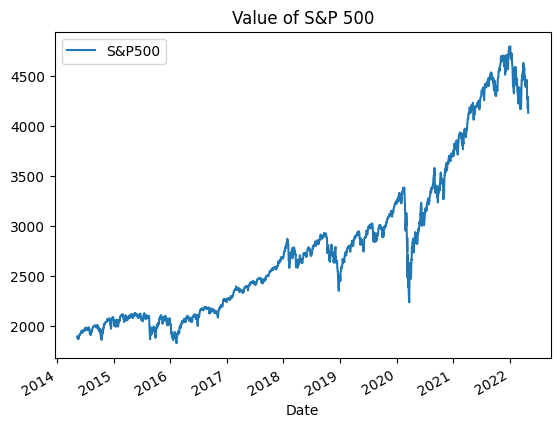

In [12]:
# Plot S&P 500 index value over time
df.plot(x='Date', y='S&P500', title='Value of S&P 500')

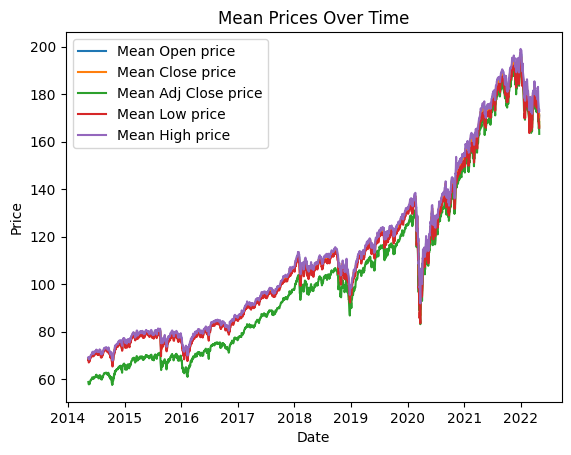

In [13]:
# Plot mean prices over time
mean_open = df.pivot(index='Date', columns='Symbol', values=['Open']).mean(axis=1)
mean_close = df.pivot(index='Date', columns='Symbol', values=['Close']).mean(axis=1)
mean_adj_close = df.pivot(index='Date', columns='Symbol', values=['Adj Close']).mean(axis=1)
mean_low = df.pivot(index='Date', columns='Symbol', values=['Low']).mean(axis=1)
mean_high = df.pivot(index='Date', columns='Symbol', values=['High']).mean(axis=1)
plt.plot(mean_open, label='Mean Open price')
plt.plot(mean_close, label='Mean Close price')
plt.plot(mean_adj_close, label='Mean Adj Close price')
plt.plot(mean_low, label='Mean Low price')
plt.plot(mean_high, label='Mean High price')
plt.title('Mean Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

<Axes: title={'center': 'Mean Trading Volume of S&P 500 Constituents Over Time'}, xlabel='Date'>

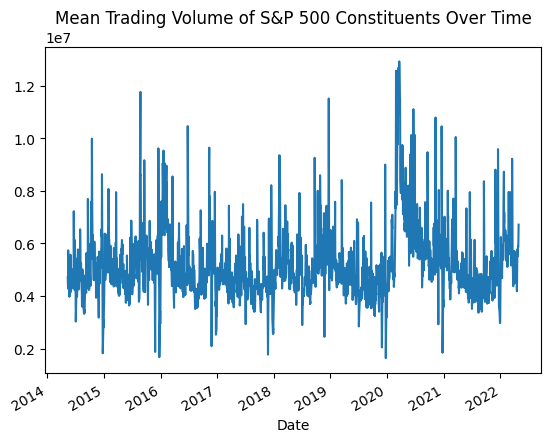

In [14]:
# Plot median trading volume over time
df.pivot(index='Date', columns='Symbol', values='Volume').mean(axis=1).plot(title='Mean Trading Volume of S&P 500 Constituents Over Time')

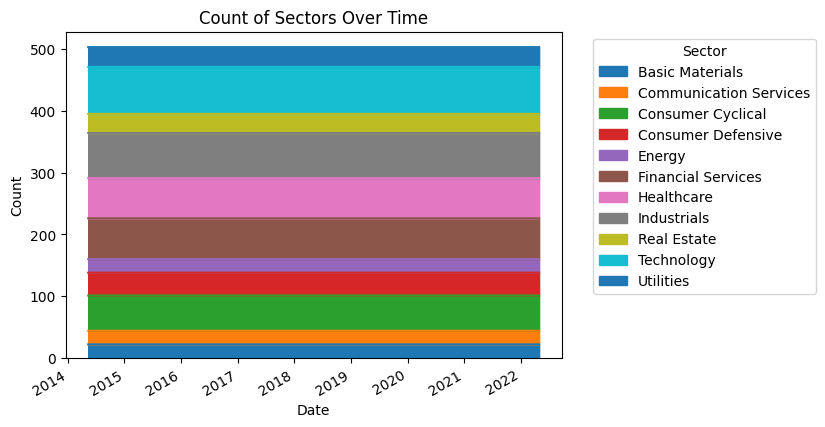

In [15]:
# Plot current sector distribution
sector_counts = df.groupby('Date')['Sector'].value_counts().unstack(fill_value=0)
sector_counts.plot(kind='area')
plt.title('Count of Sectors Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

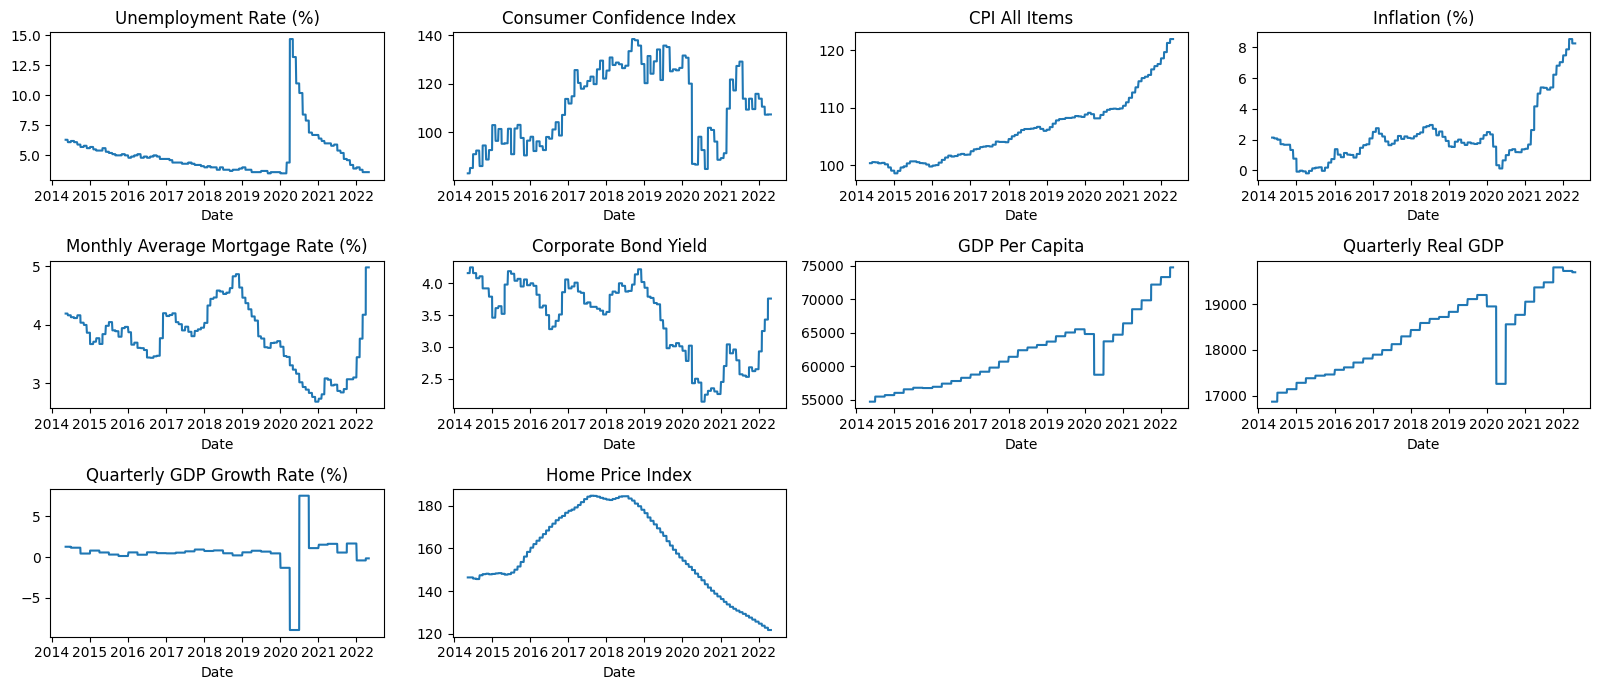

In [16]:
###########################
# Plot macro indicators
###########################

# Cols to plot
macro_cols = ['Unemployment Rate (%)',
       'Consumer Confidence Index', 'CPI All Items', 'Inflation (%)',
       'Monthly Average Mortgage Rate (%)',
       'Corporate Bond Yield', 'GDP Per Capita', 'Quarterly Real GDP',
       'Quarterly GDP Growth Rate (%)', 'Home Price Index']

# Calculate the number of rows and columns for the grid layout
num_plots = len(macro_cols)
num_rows = (num_plots - 1) // 4 + 1  # Number of rows (4 plots per row)
num_cols = min(num_plots, 4)  # Number of columns (maximum 4 plots per row)

# Create the subplots with the desired grid layout
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 7))

# Iterate over each column and plot in the corresponding subplot
for i, column in enumerate(macro_cols):
    row = i // num_cols 
    col = i % num_cols

    # Select the appropriate subplot
    if num_rows > 1:
        ax = axes[row, col]
    else:
        ax = axes[col]
    
    # Plot
    ax.plot(df['Date'], df[column])
    ax.set_title(column)
    ax.set_xlabel('Date') 

# Remove any empty subplots
if num_plots < num_rows * num_cols:
    if num_rows > 1:
        for i in range(num_plots, num_rows * num_cols):
            fig.delaxes(axes[i // num_cols, i % num_cols])
    else:
        for i in range(num_plots, num_rows * num_cols):
            fig.delaxes(axes[i])

# Adjust spacing
plt.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing between subplots
plt.tight_layout()  # Adjust the spacing between subplots

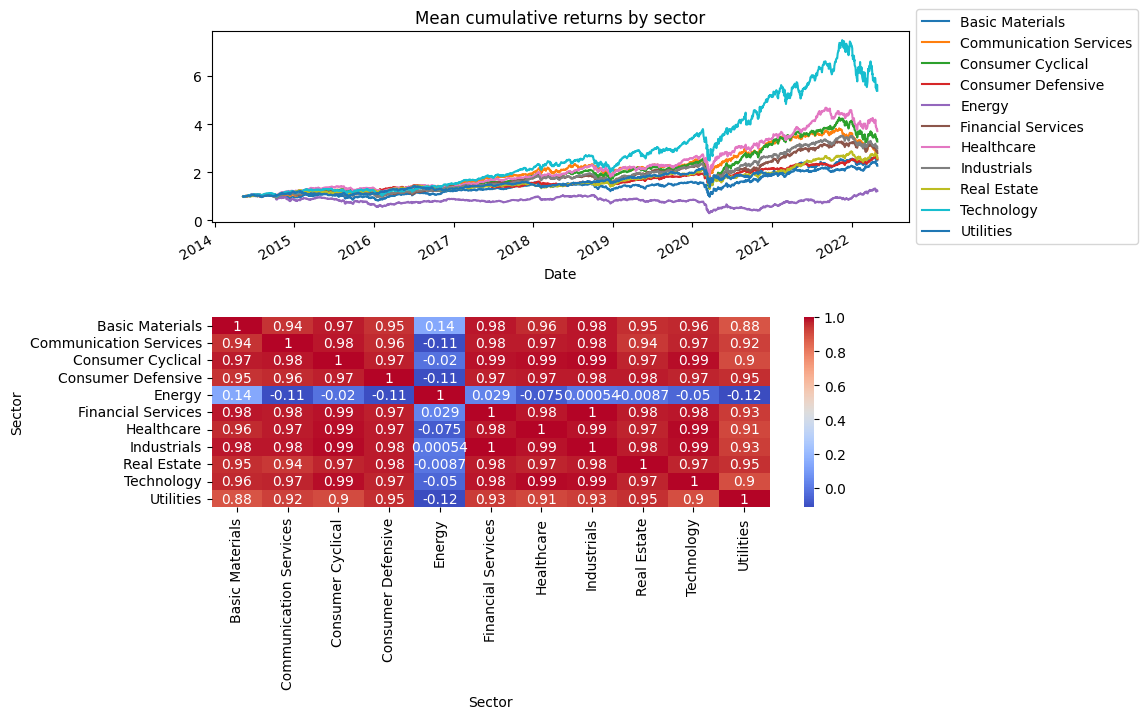

In [17]:
#############################################################################
# Returns in each sector and their correlations
#############################################################################

# Calulate cumulative returns using 1-day forward returns
sector_returns_df = df[['Date', 'Symbol', 'Sector', 'Adj Close']].copy()
sector_returns_df['1-Day Forward Adj Close'] = sector_returns_df.groupby('Symbol')['Adj Close'].shift(-1)
sector_returns_df['1-Day Forward Return'] = (sector_returns_df['1-Day Forward Adj Close'] - sector_returns_df['Adj Close']) / sector_returns_df['Adj Close']
sector_returns_df.drop('1-Day Forward Adj Close', axis=1, inplace=True)
sector_returns_df['Cumulative Return'] = sector_returns_df.groupby('Symbol')['1-Day Forward Return'].transform(lambda x: (1 + x).cumprod())

# Calculate mean cumulative return by sector at each date
sector_returns_df = sector_returns_df.pivot_table(index='Date', columns='Sector', values='Cumulative Return', aggfunc='mean')

# Calculate and plot sector returns and correlation matrix
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 7))
sector_returns_df.plot(ax=ax1, title='Mean cumulative returns by sector')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
sector_correlations = sector_returns_df.corr()
sns.heatmap(sector_correlations, annot=True, cmap='coolwarm', ax=ax2)
plt.subplots_adjust(hspace=0.5)
plt.show()

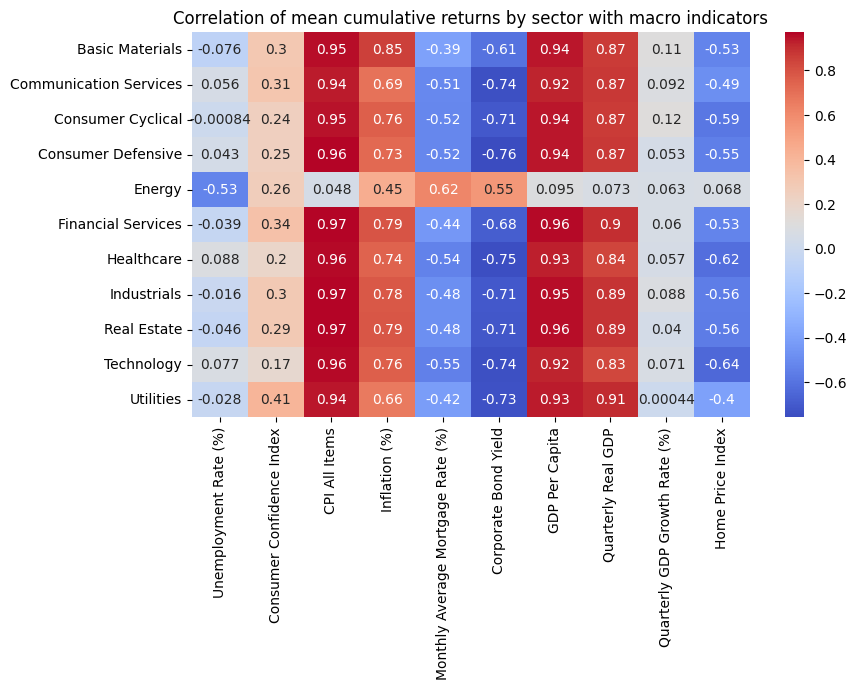

In [18]:
###############################################################
# Correlation of sector level returns with each macro indicator
###############################################################
# Combine macro data with sector returns data
sector_returns_with_macro = pd.merge(
    left=sector_returns_df,
    right=df[['Date'] + macro_cols],
    how='left',
    on='Date'
)

# Calculate correlation matrix of sector-level returns with macro indicator
macro_sector_correlation = sector_returns_with_macro.drop('Date', axis=1).corr()
unique_sectors = list(df['Sector'].dropna().unique())
macro_sector_correlation.drop(unique_sectors, axis=1, inplace=True)
macro_sector_correlation.drop(macro_cols, axis=0, inplace=True)

# Plot correlation matrix
fig, ax = plt.subplots(figsize=(9,5)) 
sns.heatmap(macro_sector_correlation, annot=True, cmap='coolwarm', ax=ax)
ax.set_title("Correlation of mean cumulative returns by sector with macro indicators")
plt.show()


# Data cleaning

The first thing to note is that the dataset is all current S&P 500 constituents historically, rather than consituents at the time, so there is some inherent survivorship bias. Also, it turns out that we get data for a ticker when the stock goes public - which is before it enters the index. Before the ticker goes public, we have no pricing data. We can't backfill as this would cause look-ahead bias and doesn't make sense anyway since those stocks wouldn't have had prices. It turns out that if we simply drop all the stocks that don't have pricing data at the start (because they're not listed), this actually removes all the nans in the pricing/volume dataset. This still leaves us with more than 400 names so it's not too bad. If there were any nans we would use forward filling at a stock level to avoid look-ahead bias of linear interpolation.

In [19]:
# Get df of first date 
first_date = df['Date'].min()
mask = df['Date'] == first_date
first_date_df = df[mask]

# Get tickers with no data in numeircal columns at first date
numerical_cols = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'S&P500']
symbols_with_nans = first_date_df[first_date_df[numerical_cols].isnull().any(axis=1)]['Symbol']

# Drop tickers that don't have data at the start
df = df[~df['Symbol'].isin(symbols_with_nans)]

# Print number of names left. Confirm there are no nulls left
print(f"There are {len(df['Symbol'].unique())} tickers remaining")
print(df.isnull().value_counts())

# Reset index
df = df.reset_index(drop=True)

There are 468 tickers remaining
Date   Symbol  Adj Close  Close  High   Low    Open   Volume  S&P500  Sector  Unemployment Rate (%)  Consumer Confidence Index  CPI All Items  Inflation (%)  Monthly Average Mortgage Rate (%)  Corporate Bond Yield  GDP Per Capita  Quarterly Real GDP  Quarterly GDP Growth Rate (%)  Home Price Index
False  False   False      False  False  False  False  False   False   False   False                  False                      False          False          False                              False                 False           False               False                          False               939744
Name: count, dtype: int64


# Feature Engineering

### Categorical variables

In [20]:
# One hot encode categorical features
categorical_cols = ['Sector']
df = pd.get_dummies(
    data=df,
    columns=categorical_cols,
    dtype=int
)

In [21]:
# Change symbol to stock id
df['Symbol'] = df['Symbol'].rank(method='dense', ascending=False).astype(int)

### Date-related

In [22]:
# Get year, month and day
df['Year'] = df['Date'].dt.year.astype(int)
df['Month'] = df['Date'].dt.month.astype(int)
df['Day'] = df['Date'].dt.day.astype(int)

### Static (based off of today's data)

In [23]:
# Daily variation (high - low) / open
df['Daily Variation'] = (df['High'] - df['Low']) / df['Open']

# Downward pressure on the stock (high - close) / open
df['Downward Pressure'] = (df['High'] - df['Close']) / df['Open']

# Upward pressure on the stock (low - open) / open
df['Upward Pressure'] = (df['Low'] - df['Open']) / df['Open']

 ### Shifted

In [24]:
# List of days and cols to to shift by
to_shift_by = [1, 3, 5, 10, 15, 30, 60]
to_shift = macro_cols + ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'S&P500']

# Get shifted dataframes for each time period
shifted_dfs = []
groups = df.groupby('Symbol')[to_shift]
for d in to_shift_by:
    # Get shifted df
    shifted_df = groups.shift(periods=d)
    
    # Edit column names
    shifted_df.columns = [f"{c} {d}-Day Shifted" for c in to_shift]
    
    # Append to list
    shifted_dfs.append(shifted_df)

# Concatenate shifted dataframes to original dataframe
df = pd.concat(
    [df] + shifted_dfs,
    axis=1
)

### Returns/Changes

In [25]:
# % Change cols
pct_change_cols = ['Adj Close', 'S&P500'] + macro_cols

# Get shifted dataframes for each time period
change_dfs = []
for d in to_shift_by:
    # Get dataframe of shifted columns
    shifted_cols = [f"{c} {d}-Day Shifted" for c in pct_change_cols]
    shifted_df = df[shifted_cols]
    
    # Calculate percentage change
    pct_changes = 100 * (np.array(df[pct_change_cols]) - np.array(shifted_df)) / np.array(shifted_df)
    change_df = pd.DataFrame(
        data=pct_changes,
        columns=[f"{c} {d}-Day % Change" for c in pct_change_cols]
    )

    # Append to list
    change_dfs.append(change_df)

# Append to original dataframe
df = pd.concat(
    [df] + change_dfs,
    axis=1
)

### Rolling

In [26]:
# Columns to calculate SMA, EMA, std for
cols = ['Adj Close', 'Volume']
days = [7, 12, 14, 26]

# List of dataframes of rolling features
rolling_dfs = []

# For each lookback, calculate rolling features
for d in days:
    # Get groupby object
    groupby = df.groupby('Symbol')[cols]
    
    # SMA
    df_sma = groupby.transform(lambda x: x.rolling(d).mean())
    df_sma.columns = [f"{c} {d}-Day SMA" for c in cols]

    # EMA
    df_ema = groupby.transform(lambda x: x.ewm(span=d, min_periods=d).mean())
    df_ema.columns = [f"{c} {d}-Day EMA" for c in cols]

    # Std
    df_std = groupby.transform(lambda x: x.rolling(d).std())
    df_std.columns = [f"{c} {d}-Day std" for c in cols]
    
    # Create df of all rolling features and append to list
    rolling_df = pd.concat(
        [df_sma, df_ema, df_std],
        axis=1
    )
    rolling_dfs.append(rolling_df)
    
# Append to original dataframe
df = pd.concat(
    [df] + rolling_dfs,
    axis=1
)

### Technical indicators

In [27]:
##################################################
# Bollinger Bands
##################################################

# Bollinger bands
df['Adj Close 7-Day Upper Bollinger Band'] = df['Adj Close 7-Day SMA'] + (2 * df['Adj Close 7-Day std'])
df['Adj Close 7-Day Lower Bollinger Band'] = df['Adj Close 7-Day SMA'] - (2 * df['Adj Close 7-Day std'])

# Distance to bollinger bands
df['Distance to Adj Close 7-Day Upper Bollinger Band'] = df['Adj Close'] - df['Adj Close 7-Day Upper Bollinger Band']
df['Distance to Adj Close 7-Day Lower Bollinger Band'] = df['Adj Close'] - df['Adj Close 7-Day Lower Bollinger Band']

In [28]:
###################################################
# Average True Range (ATR)
###################################################

# Calculate 3 measures of volatility (that we will take average of for ATR)
high_minus_low = df['High'] - df['Low']
high_minus_yday_adj_close = (df['High'] - df['Adj Close 1-Day Shifted']).abs()
low_minus_yday_adj_close = (df['Low'] - df['Adj Close 1-Day Shifted']).abs()

# Calculate true range and (7-day) average true range
df['True Range'] = np.maximum.reduce([high_minus_low, high_minus_yday_adj_close, low_minus_yday_adj_close])
df['True Range 26-Day SMA'] = df.groupby('Symbol')['True Range'].transform(lambda x: x.rolling(26).mean())

In [29]:
###################################################
# Moving Average Convergence Divergence (MACD)
###################################################

# MACD https://www.investopedia.com/terms/m/macd.asp
df['MACD'] = df['Adj Close 12-Day EMA'] - df['Adj Close 26-Day EMA']
df['MACD Signal Line'] = df.groupby('Symbol')['MACD'].transform(lambda x: x.ewm(span=9, min_periods=9).mean())
df['MACD Histogram'] = df['MACD'] - df['MACD Signal Line']

In [30]:
#######################################################################
# Moving Average Convergence Divergence (Volatility Adjusted) (MACD-V)
#######################################################################

# MACD-v (same as MACD but normalized for vol)
df['MACD-V'] = 100 * (df['Adj Close 12-Day EMA'] - df['Adj Close 26-Day EMA']) / df['True Range 26-Day SMA']
df['MACD-V Signal Line'] = df.groupby('Symbol')['MACD-V'].transform(lambda x: x.ewm(span=9, min_periods=9).mean())
df['MACD-V Histogram'] = df['MACD-V'] - df['MACD-V Signal Line']

In [31]:
###################################################
# Stochastic Oscillator
###################################################

# Get min and max prices over last 14 days
min_prices = df.groupby('Symbol')['Low'].transform(lambda x: x.rolling(14).min())
max_prices = df.groupby('Symbol')['High'].transform(lambda x: x.rolling(14).max())

# Stochatic Oscillator https://www.investopedia.com/terms/s/stochasticoscillator.asp
df['Stochastic Oscillator %K'] = 100 * (df['Close'] - min_prices) / (max_prices - min_prices)
df['Stochastic Oscillator %D'] = df.groupby('Symbol')['Stochastic Oscillator %K'].transform(lambda x: x.rolling(3).mean())
df['Stochastic Oscillator Histogram'] = df['Stochastic Oscillator %K'] - df['Stochastic Oscillator %D']

### Target

In [32]:
# Calculate Forward Excess Return
df['1-week Forward Adj Close'] = df.groupby('Symbol')['Adj Close'].shift(-5)
df['1-week Forward Return'] = (df['1-week Forward Adj Close'] - df['Adj Close']) / df['Adj Close']

# Create targets from forward returns (sign of return)
df['1-week Forward Return Sign'] = np.sign(df['1-week Forward Return'])

# Drop redundant columns
df.drop(['1-week Forward Adj Close', '1-week Forward Return'], axis=1, inplace=True)

### Plots for a single stock

In [33]:
# Get dataframe of some stock to use for plots
test_df = df[df['Symbol'] == 1].tail(150)

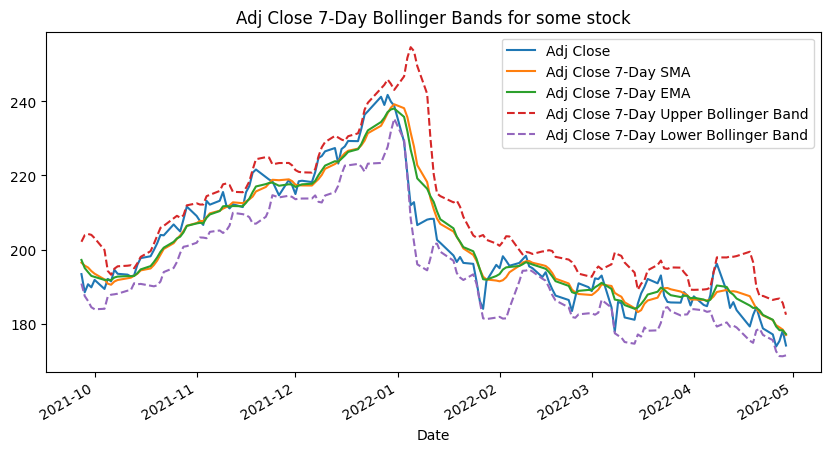

In [34]:
# Plot SMA, EMA and price. Note how EMA responds quicker to price swings than SMA
cols_to_plot = ['Adj Close', 'Adj Close 7-Day SMA', 'Adj Close 7-Day EMA', 'Adj Close 7-Day Upper Bollinger Band', 'Adj Close 7-Day Lower Bollinger Band']
line_styles = {'Adj Close 7-Day Upper Bollinger Band': '--', 'Adj Close 7-Day Lower Bollinger Band': '--'}
ax = test_df.plot(x ='Date', y=cols_to_plot, figsize=(10, 5), style=line_styles, title='Adj Close 7-Day Bollinger Bands for some stock')
ax.legend(bbox_to_anchor=(1, 1))

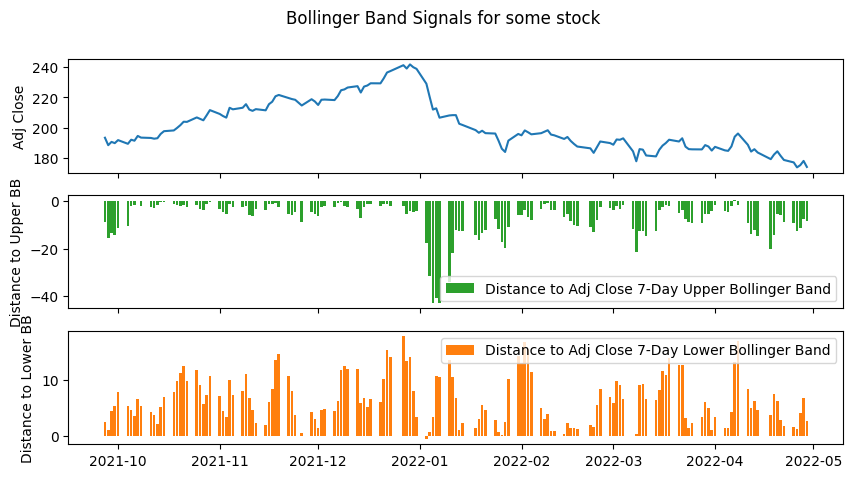

In [35]:
# Plot price vs distance to bollinger bands
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 5))

# Plot the stock price on the first (top) subplot
ax1.plot(test_df['Date'], test_df['Adj Close'], color='tab:blue')
ax1.set_ylabel('Adj Close')

# Plot the BBs and distance to BBs on the second (bottom) subplot
ax2.bar(test_df['Date'], test_df['Distance to Adj Close 7-Day Upper Bollinger Band'], color='tab:green', label='Distance to Adj Close 7-Day Upper Bollinger Band')
ax3.bar(test_df['Date'], test_df['Distance to Adj Close 7-Day Lower Bollinger Band'], color='tab:orange', label='Distance to Adj Close 7-Day Lower Bollinger Band')
ax2.set_ylabel('Distance to Upper BB')
ax3.set_ylabel('Distance to Lower BB')
ax2.legend()
ax3.legend()
fig.suptitle('Bollinger Band Signals for some stock')
plt.show()

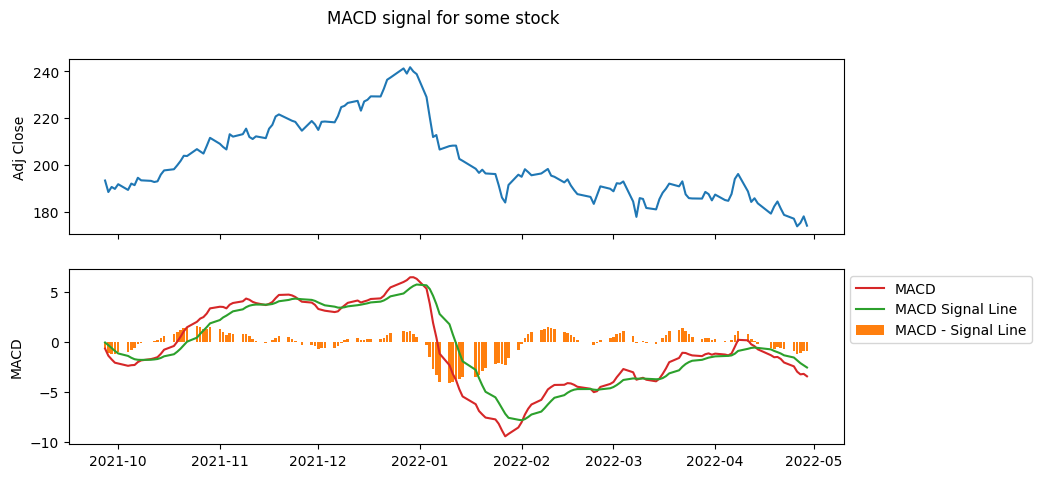

In [36]:
# Plot MACD and MACD Signal for some stock
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))  # Two subplots sharing the same x axis

# Plot the stock price on the first (top) subplot
ax1.plot(test_df['Date'], test_df['Adj Close'], color='tab:blue')
ax1.set_ylabel('Adj Close')

# Plot the MACD line and signal line on the second (bottom) subplot
ax2.plot(test_df['Date'], test_df['MACD'], color='tab:red', label='MACD')
ax2.plot(test_df['Date'], test_df['MACD Signal Line'], color='tab:green', label='MACD Signal Line')
ax2.bar(test_df['Date'], test_df['MACD Histogram'], color='tab:orange', label='MACD - Signal Line')
ax2.set_ylabel('MACD')
ax2.legend(bbox_to_anchor=(1, 1))
fig.suptitle('MACD signal for some stock')
plt.show()

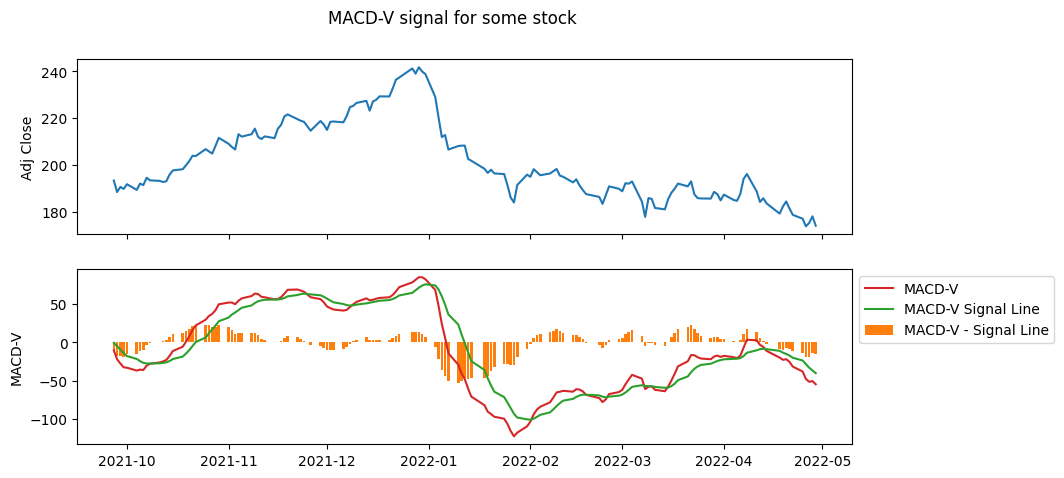

In [37]:
# Plot MACD-V and MACD-V Signal for some stock
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))  # Two subplots sharing the same x axis

# Plot the stock price on the first (top) subplot
ax1.plot(test_df['Date'], test_df['Adj Close'], color='tab:blue')
ax1.set_ylabel('Adj Close')

# Plot the MACD-V line and signal line on the second (bottom) subplot
ax2.plot(test_df['Date'], test_df['MACD-V'], color='tab:red', label='MACD-V')
ax2.plot(test_df['Date'], test_df['MACD-V Signal Line'], color='tab:green', label='MACD-V Signal Line')
ax2.bar(test_df['Date'], test_df['MACD-V Histogram'], color='tab:orange', label='MACD-V - Signal Line')
ax2.set_ylabel('MACD-V')
ax2.legend(bbox_to_anchor=(1, 1))
fig.suptitle('MACD-V signal for some stock')
plt.show()

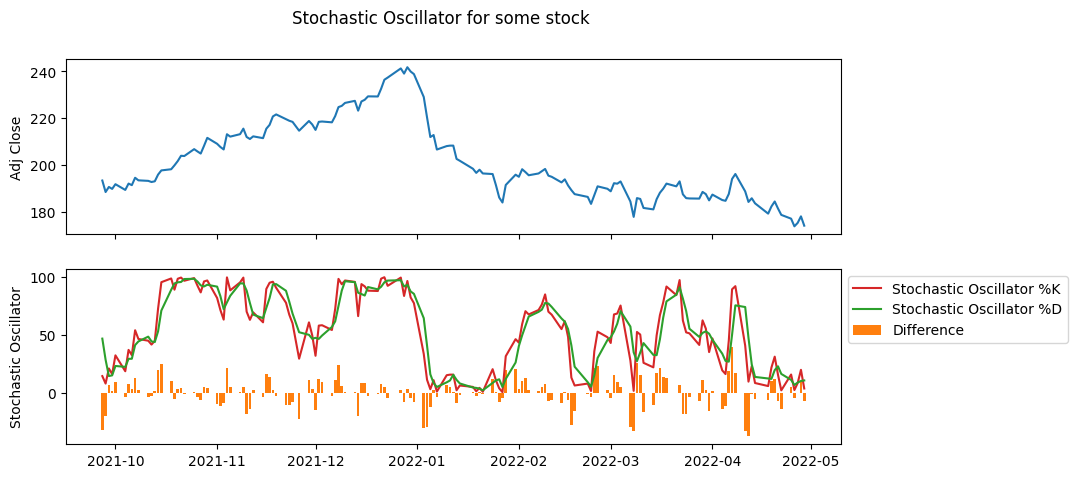

In [38]:
# Plot stochastic oscillator for some stock
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))  # Two subplots sharing the same x axis

# Plot the stock price on the first (top) subplot
ax1.plot(test_df['Date'], test_df['Adj Close'], color='tab:blue')
ax1.set_ylabel('Adj Close')

# Plot the stochastic oscillator and signal line on the second (bottom) subplot
ax2.plot(test_df['Date'], test_df['Stochastic Oscillator %K'], color='tab:red', label='Stochastic Oscillator %K')
ax2.plot(test_df['Date'], test_df['Stochastic Oscillator %D'], color='tab:green', label='Stochastic Oscillator %D')
ax2.bar(test_df['Date'], test_df['Stochastic Oscillator Histogram'], color='tab:orange', label='Difference')
ax2.set_ylabel('Stochastic Oscillator')
ax2.legend(bbox_to_anchor=(1, 1))
fig.suptitle('Stochastic Oscillator for some stock')
plt.show()

# Write Output

In [39]:
# Drop redundant columns
redundant_cols = ['Date']
df.drop(redundant_cols, axis=1, inplace=True)

# Drop rows that have NaNs due to forward-looking target or back-looking features
df.dropna(ignore_index=True, inplace=True)

In [40]:
# Write to file
df.to_csv(path_or_buf="all_data.csv")